In [3]:
import numpy as np
from scipy import stats
from scipy.linalg import eig
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from bayesiankalman import mcmc
from tqdm import tqdm
import seaborn as sns
import statsmodels.api as sm
import cdpm
from cdpm import CondDirichletProcessMix
from pandas_datareader import data as web
from sklearn.preprocessing import normalize

In [4]:
%matplotlib inline
mpl.style.use('seaborn-talk')

In [5]:
alpha_for_ci = .95
num_draws = int(1e4)

In [6]:
data_tmp = web.DataReader('CPIAUCSL', data_source='fred', start='1900-01-01').apply(np.log).diff().dropna()
#data_tmp = web.DataReader('QUSR628BIS', data_source='fred', start='1900-01-01').apply(np.log).diff().dropna()
#QUSR628BIS: real residential property price (US)
#CPIAUCSL: CPI for all urban consumers
# data_tmp = pd.read_excel('/home/sangrey/Downloads/HPI_PO_monthly_hist.xls', header=2, index_col='Month').dropna(
#     how='all').iloc[:,0].to_frame().apply(np.log).diff()
recessions_tmp = web.DataReader('USREC', data_source='fred', start='1900-01-01')
data = pd.merge(left=data_tmp - data_tmp.mean(), right=recessions_tmp, left_index=True,
                right_index=True).ffill().dropna()
data.columns = ['Data', 'Recessions']
data['Data'] = data['Data'].apply(lambda x: x / data['Data'].std())

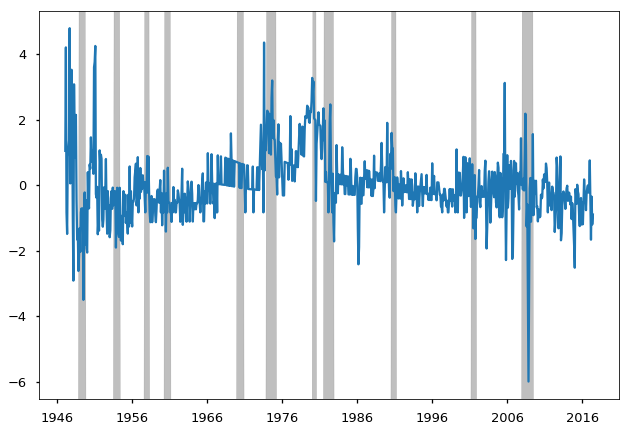

In [7]:
data_fig, data_ax = plt.subplots(1,1)
data_ax.plot(data['Data'])
minval, maxval = data_ax.get_ylim()
data_ax.set_ylim([minval, maxval])
data_ax.fill(data['Recessions'] * (maxval - minval) + minval, color='grey', alpha=.5)

In [8]:
data.describe()

Data  Recessions
count  8.450000e+02  845.000000
mean   1.679130e-16    0.144379
std    1.000000e+00    0.351681
min   -5.990868e+00    0.000000
25%   -5.398741e-01    0.000000
50%   -1.230028e-01    0.000000
75%    4.491695e-01    0.000000
max    4.788811e+00    1.000000

## Estimation

In [23]:
time_dim = data.shape[0]
regressor_dim = 1
regressand_dim = 1loc[:10]

In [24]:
# stick_scale = 2
# beta_mu, beta_sigma = .9, 0.1  # mean and standard deviation
# precn_df, precn_scale = 2, 1

In [25]:
stick_scale = 2
# mean and standard deviation
beta_mu, beta_sigma = 0 * np.asarray([1]), 0.05 * np.eye(regressand_dim, regressand_dim) 
comp_cov_df, comp_cov_scale = 3, .5 * np.eye(regressand_dim,regressand_dim)

In [26]:
prior = {
    'comp': {
        'coeff': {'mean': [beta_mu], 'cov': [beta_sigma]},
        'precn': {'scale': [precn_scale**(-1)], 'shape': [precn_df]}
    },
    'sticks': {
        'params': {
            'c': [stick_scale]
        }
    }
}

In [21]:
## Initialization
model = CondDirichletProcessMix(np.asarray(beta_mu), comp_cov=np.asarray(tau_precn),regressor=data['Data'].iloc[:-1].values, 
                                regressand=data['Data'].iloc[1:].values)

NameError: name 'tau_precn' is not defined

In [13]:
time_dim = data.shape[0]
cluster_identity_draws = np.empty((num_draws, time_dim-1))
stick_draws = np.full((num_draws, 50),np.nan)
beta_draws = np.full((num_draws, 50),np.nan)
precision_draws = np.full((num_draws, 50),np.nan)
trans_mat_draws = np.full((num_draws, 50, 50),np.nan)

In [14]:
for draw_idx in tqdm(range(num_draws)):
    model_posterior = model(prior)
    cluster_identity_draws[draw_idx] = model_posterior[0]
    stick_draws[draw_idx,:len(model_posterior[1])] = model_posterior[1]
    beta_draws[draw_idx,:len(model_posterior[2])] = np.squeeze(model_posterior[2]) 
    precision_draws[draw_idx,:len(model_posterior[3])] = model_posterior[3]
    trans_mat_draws[draw_idx,:model_posterior[4].shape[0], :model_posterior[4].shape[1]] = model_posterior[4]

  0%|          | 0/10000 [00:00<?, ?it/s]


NameError: name 'model' is not defined

## Simulation results

In [15]:
percentiles = [1,5, 25, 50, 75, 95, 99]

In [ ]:
state_quantiles = np.percentile(cluster_identity_draws, percentiles, axis=0)

## Get the dynamics of Housing Starts

In [ ]:
beta_est = pd.DataFrame(beta_draws)
sigma_est = pd.DataFrame(precision_draws)**(-1/2)

In [ ]:
beta_est.describe().dropna(axis=1)

In [ ]:
sigma_est.describe().dropna(axis=1)

In [ ]:
data_est_mat = np.empty((time_dim-1, num_draws))

In [ ]:
trans_mat = pd.DataFrame(np.nanmean(trans_mat_draws[:, :5, :5], axis=0))
trans_mat

In [ ]:
def get_eigvecs_with_eigval_close_to_1(mat):
    
    mat = pd.DataFrame(mat).dropna(axis=0, how='all').dropna(axis=1).T
    
    eigvals, eigvecs = eig(mat)
    
    idx = np.argsort(eigvals)[::-1][0]
    
    return pd.DataFrame(np.clip(np.real(eigvecs[:, idx]), a_min=0, a_max=1)).T

In [ ]:
def compute_stationary_distribution(trans_mat_draws):
    
    stat_dist = map(get_eigvecs_with_eigval_close_to_1, tqdm(trans_mat_draws))
    
    return_df = pd.concat(stat_dist, join='outer')
    return_df.index = range(len(trans_mat_draws))

    return return_df

In [ ]:
stationary_dist = compute_stationary_distribution(trans_mat_draws)

In [ ]:
stationary_dist.mean().iloc[:5]

In [ ]:
sns.boxplot(data=stationary_dist.iloc[:, :5])

In [ ]:
data_est_mat = np.empty((time_dim-1, num_draws // 10))

In [ ]:
for draw in tqdm(range(num_draws // 10)):
    for t_idx in range(1, time_dim):
        cluster_identity = cluster_identity_draws[draw,t_idx-1].astype(int)
        cl_idx = np.argmax(np.random.multinomial(n=1,pvals=trans_mat_draws[draw][cluster_identity,:]).astype(np.bool))
        data_f = (data['Data'].iloc[t_idx-1] * beta_draws[draw, cl_idx] 
                   + precision_draws[draw, cl_idx]**(-.5) * np.random.normal(0,1, size=1))
        data_est_mat[t_idx-1, draw] = np.asscalar(data_f)

In [ ]:
cluster_id_fig, cluster_id_ax = plt.subplots(1,1)
mcmc.fan_plot(cluster_id_ax, pd.DataFrame(cluster_identity_draws.T, index=data.index[1:]),  percentiles, 
              color='black')

In [ ]:
np.nanstd(data_est_mat)

In [ ]:
data['Data'].std()

In [ ]:
pd.DataFrame(data_est_mat).head()

In [ ]:
pd.DataFrame(np.nanpercentile(data_est_mat, q=percentiles, axis=1)).T.plot()

In [ ]:
data_comparison_fig, data_comparison_ax = plt.subplots(1,1)
mcmc.fan_plot(data_comparison_ax, pd.DataFrame(data_est_mat, index=data.index[1:]), percentiles, color='black')
data['Data'].plot(ax=data_comparison_ax, c='red')
for label in data_comparison_ax.get_xticklabels():
    label.set_fontsize(20)
for label in data_comparison_ax.get_yticklabels():
    label.set_fontsize(20)
minval, maxval = data_comparison_ax.get_ylim()
data_comparison_ax.fill(data['Recessions'] * (maxval - minval) + minval, color='grey', alpha=.5)
data_comparison_filename = '../doc/figures/data_series_housep.tmp.png'
data_comparison_fig.savefig(data_comparison_filename, bbox_inches='tight', pad_inches=0)

In [ ]:
pd.DataFrame(data_est_mat, index=data.index[1:])[400:]

In [ ]:
data_comparison_fig2, data_comparison_ax2 = plt.subplots(1,1)
mcmc.fan_plot(data_comparison_ax2, pd.DataFrame(data_est_mat, index=data.index[1:])[500:], percentiles, color='black')
data['Data'][500:].plot(ax=data_comparison_ax2, c='red')
for label in data_comparison_ax2.get_xticklabels():
    label.set_fontsize(20)
for label in data_comparison_ax2.get_yticklabels():
    label.set_fontsize(20)
minval, maxval = data_comparison_ax2.get_ylim()
data_comparison_ax2.fill(data['Recessions'] * (maxval - minval) + minval, color='grey', alpha=.5)
data_comparison_filename = '../doc/figures/data_series_housep_zoom.tmp.png'
data_comparison_fig2.savefig(data_comparison_filename, bbox_inches='tight', pad_inches=0)

In [ ]:
pit1 = mcmc.probability_integral_transform(pd.DataFrame(data_est_mat, index=data.index[1:]).dropna(axis=1), 
                                           data['Data'].iloc[1:])

In [ ]:
pit_fig = plt.figure()
pit_ax = pit_fig.add_subplot(111)
nbins = 10
sns.distplot(pit1, kde=False, norm_hist=True, ax=pit_ax, bins=nbins)
pit_ax.set_xlim([0,1])
pit_ax.set_ylim([0,1.5])
for label in pit_ax.get_xticklabels():
    label.set_fontsize(20)
for label in pit_ax.get_yticklabels():
    label.set_fontsize(20)
pit_ci_bottom, pit_ci_top = stats.binom.interval(alpha=alpha_for_ci, n=pit1.size, p=nbins**(-1)) 
pit_ax.axhline(pit_ci_bottom * (nbins / pit1.size), color='red', linestyle='dashed')
pit_ax.axhline(pit_ci_top * (nbins / pit1.size), color='red', linestyle='dashed')
pit_ax.axhline(1, color='black')
pit_filename = '../doc/figures/pit_housep.tmp.png'
pit_fig.savefig(pit_filename, bbox_inches='tight', pad_inches=0)

In [ ]:
acf_fig = plt.figure()
acf_ax = acf_fig.add_subplot(111)
acf_ax.plot(sm.tsa.acf(pit1)[1:])
acf_ax.set_ylim([-1,1])
for label in acf_ax.get_xticklabels():
    label.set_fontsize(20)
for label in acf_ax.get_yticklabels():
    label.set_fontsize(20)
acf_ax.set_xlim([0, 40])
acf_filename = '../doc/figures/acf_housep.tmp.png'
acf_fig.savefig(acf_filename, bbox_inches='tight', pad_inches=0)